In [26]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa import time
import matplotlib.pyplot as plt
import numpy as np
import random
from mesa.datacollection import DataCollector
%matplotlib inline

Parametros

In [27]:
WIDTH = 50
HEIGHT = WIDTH
NUM_COLONOS = WIDTH
NUM_CIUDADES = 5
NUM_NATIVOS = 100
TASA_COLONOS = 180
CULTURA = 0.01 
REPRODUCCION = 0.05


Colonos

In [28]:
class Colono(Agent):

    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, model)

        self.pos = pos
        self.reproducirse =  REPRODUCCION

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )
        # Calcula la cantidad de celdas ocupadas por colonos en la vecindad
        celdas_ocupadas_vecindad = sum(1 for pos in possible_steps if pos in self.model.celdas_ocupadas_colonos)
        # Calcula las probabilidades de movimiento ponderadas por la ocupación de celdas
        probabilities = [1.0 if pos in self.model.celdas_ocupadas_colonos else 0.5 for pos in possible_steps]
        probabilities = [prob / sum(probabilities) for prob in probabilities]
        # Elige una nueva posición según las probabilidades
        new_position = self.random.choices(possible_steps, weights=probabilities, k=1)[0]
        # Mueve al colono y actualiza la posición y el conjunto de celdas ocupadas
        self.model.grid.move_agent(self, new_position)
        self.pos = new_position
        self.model.celdas_ocupadas_colonos.add(new_position)  # Agrega la nueva posición

    def step(self):
        self.move()
        return
    
    

Nativos

In [29]:
class Nativo(Agent):

    def __init__(self, unique_id, pos, cultura, model, aldea):
        super().__init__(unique_id, model)
        
        self.cultura = cultura
        self.pos = pos
        self.reproducirse = REPRODUCCION
        self.aldea = aldea
        self.cultura = self.aldea.cultura

    def move(self):

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=False,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        x1, y1 = new_position
        x2, y2 = self.aldea.pos
        distance = abs(x1-x2) + abs(y1-y2)
        old_pos = (x1, y1)
        
        self.model.grid.move_agent(self, new_position)
        self.pos = new_position

        if distance>10:
            self.model.grid.move_agent(self, old_pos)
            self.pos = old_pos
        
    def reproduccion(self):
        posibilidades = [0, 1]

        eleccion = random.choices(posibilidades, weights = (1 - self.reproducirse, self.reproducirse), k = 1)

        if 0 in eleccion:
            return

        else:
            nativo = Nativo(self.model.next_id(), self.pos, 0.5 * self.cultura, self.model, self.aldea) 
            self.model.schedule.add(nativo)
            self.model.grid.place_agent(nativo, self.pos)
            self.reproducirse = self.reproducirse * 0.25 

    def batalla(self):
        ### SELECCIONAR COLONO, DECIDIR HUIR O PELEAR, CONTAR NATIVOS, REPETIR ESTO EN EL ARCHIVO DE COLONOS
        cellmates_nativo = self.model.grid.get_cell_list_contents([self.pos])
        colonos = [obj for obj in cellmates_nativo if isinstance(obj, Colono)]
        if len(colonos) > 0: 
            colono = self.random.choice(colonos)
            #contar nativos
            cellmates_nativo = self.model.grid.get_cell_list_contents([self.pos])
            nativos_cercanos = [obj for obj in cellmates_nativo if isinstance(obj, Nativo)]
            num_nativos_cercanos = len(nativos_cercanos)

            # contar colonos
            cellmates_colono = colono.model.grid.get_cell_list_contents([self.pos])
            colonos_cercanos = [obj for obj in cellmates_colono if isinstance(obj, Colono)]
            num_colonos_cercanos = len(colonos_cercanos)

            if num_nativos_cercanos > 1.4 * num_colonos_cercanos: ### cambiar el numero por un parametro
              posibilidades = [0, 1]
              eleccion = random.choices(posibilidades, weights = (0.2, 0.8), k = 1) ### cambiar esto por un parametro
              if 0 in eleccion: ### nativo gana, muere colono
                colono.model.grid.remove_agent(colono)
                colono.model.schedule.remove(colono)
            

              else: ###colono gana, muere nativo
                colono.model.grid.remove_agent(self)
                for nativo in nativos_cercanos:
                    nativo.aldea.cultura += 0.1
                colono.model.schedule.remove(self)
            
            else: ###colono gana, muere nativo
                colono.model.grid.remove_agent(self)
                colono.model.schedule.remove(self)
                for nativo in nativos_cercanos:
                    nativo.aldea.cultura += 0.1
            return
        
        else:
            return
        

    def step(self):
        cultura = self.cultura
        reproducirse = self.reproducirse
        total = cultura + reproducirse
        cultura /= total
        reproducirse /= total

        weights = [1, reproducirse, cultura]
        actions = [self.move, self.reproduccion, self.batalla]
        action = self.random.choices(actions, weights=weights, k=1)[0]

        ### añadiendo la batalla a la celda correspondiente
        if action == self.batalla:
            posicion_batalla = self.pos
            self.model.celdas_batallas[posicion_batalla] += 1
        action()

Aldeas

In [30]:
class Aldea(Agent):
    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.pos = pos
        self.cultura = CULTURA 
    
    def step(self):
        return

Modelo

In [31]:
class Araucania(Model):

    def __init__(self):
        self.verbose = False
        self.current_id = 0

        self.num_colonos = NUM_COLONOS
        self.num_nativos = NUM_NATIVOS
        self.schedule = time.RandomActivation(self)
        self.grid = MultiGrid(WIDTH, HEIGHT, False)
        self.celdas_ocupadas_colonos = set()
        self.celdas_batallas = np.zeros((WIDTH, HEIGHT))

        # Creando colonos
        x = 0
        y = HEIGHT - 1

        for i in range(self.num_colonos):
            colono = Colono(self.next_id(), (x,y), self)
            self.schedule.add(colono)
            self.grid.place_agent(colono, (x, y))

            x += 1

        ids_aldeas = []
        aldeas = []
        
        
        # Creando Aldeas
        for i in range (NUM_CIUDADES):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            
            aldea = Aldea(self.next_id(), (x,y),self)
            self.schedule.add(aldea)
            self.grid.place_agent(aldea, (x, y))
            #print(aldea.pos, "posaldea")
            ids_aldeas += [aldea.unique_id]
            aldeas += [aldea]

        # Creando Nativos
        num_actual = 0
        num_aldeas = 5
        aldea_nativo=aldeas[0]

        for i in range(self.num_nativos):

            if num_actual==num_aldeas-1:
                num_actual=0
            possible_steps = aldea_nativo.model.grid.get_neighborhood(
                aldea_nativo.pos,
                moore=True,
                include_center=False)
            pos_nativo = aldea_nativo.random.choice(possible_steps)
            nativo = Nativo(self.next_id(), pos_nativo, CULTURA, self, aldeas[num_actual])
            self.schedule.add(nativo)
            self.grid.place_agent(nativo, pos_nativo)
            num_actual += 1
            aldea_nativo = aldeas[num_actual]
        
        
        self.datacollector = DataCollector(
            {
                "Nativos": lambda m: len([nativo for agent in m.schedule.agents if isinstance(agent, Nativo)]),
                "Colonos": lambda m: len([colono for agent in m.schedule.agents if isinstance(agent, Colono)]),
                "Aldeas": lambda m: len([aldea for agent in m.schedule.agents if isinstance(agent, Aldea)])
            }
        )
        
        self.datacollector.collect(self)

    def llegan_colonos(self):
        x = 0
        y = HEIGHT - 1

        for i in range(self.num_colonos):
            colono = Colono(self.next_id(), (x,y), self)
            self.schedule.add(colono)
            self.colocar_colono(colono, x, y)

            x += 1
        return
    
    def colocar_colono(self, colono, x, y):
        self.grid.place_agent(colono, (x, y))
        self.celdas_ocupadas_colonos.add((x, y))

    def step(self):
        if self.schedule.time%TASA_COLONOS==0 and self.schedule.time!=0:
            self.llegan_colonos()
        self.schedule.step()
        

        if self.verbose:
            self.datacollector.collect(self)
            print(
                [
                    self.schedule.time,
                    print(self.datacollector.get_model_vars_dataframe())
                ]
            )

    

Simulación

In [34]:
def simular(n, k):
    
    nativos = []
    colonos = []
    

    batallas = []
    aldeas = []

    for m in range (n):

        print(f"Sim {m + 1}")
        nativos.append([])
        colonos.append([])
        aldeas.append([])
        model = Araucania()
        evolucion_cultura = []
        celdas_ocupadas_colonos = []
        

        
        for i in range(k):
            evolucion_cultura.append(0)

            model.step()
            nativos[m].append(0)
            colonos[m].append(0)
            
            for agente in model.schedule.agents:
        
                if isinstance(agente, Nativo):
                    nativos[m].append(agente)
                    evolucion_cultura[i] += agente.cultura/len(nativos[m])
        
                elif isinstance(agente, Colono):
                    colonos[m].append(agente)
                
                elif isinstance(agente, Aldea):
                    if agente.pos not in aldeas[m]:
                        aldeas[m].append(agente.pos)
        
            if i%100==0:
                print("Step:", i)
                plt.imshow(model.celdas_batallas)
                ### plotear la posicion de las aldeas
                for aldea in aldeas[m]:
                    plt.scatter(aldea[0], aldea[1], c = "red")
                plt.show()
                print("Nativos:", len(nativos[m]))
                print("Colonos:", len(colonos[m]))
                print("Batallas:", model.celdas_batallas.sum())
                print("Celdas ocupadas por colonos:", len(model.celdas_ocupadas_colonos))
            celdas_ocupadas_colonos.append(len(model.celdas_ocupadas_colonos))
        
        #plot evolucion de la cultura en el tiempo

        plt.plot(range(len(evolucion_cultura)), evolucion_cultura)
        plt.xlabel("Tiempo")
        plt.ylabel("Cultura Promedio")
        plt.show()

        # plot evolucion de las celdas ocupadas por colonos en el tiempo
        plt.plot(range(len(celdas_ocupadas_colonos)), celdas_ocupadas_colonos)
        plt.xlabel('Tiempo')
        plt.ylabel('Celdas Ocupadas por Colonos')
        plt.show()


Sim 1
Step: 0


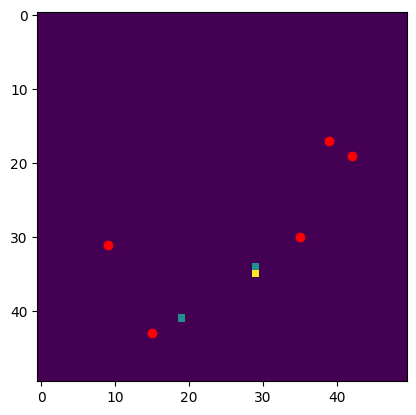

Nativos: 103
Colonos: 51
Batallas: 4.0
Celdas ocupadas por colonos: 44
Step: 100


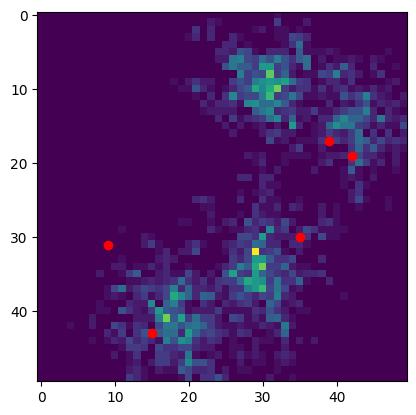

Nativos: 20814
Colonos: 5071
Batallas: 3590.0
Celdas ocupadas por colonos: 602
Step: 200


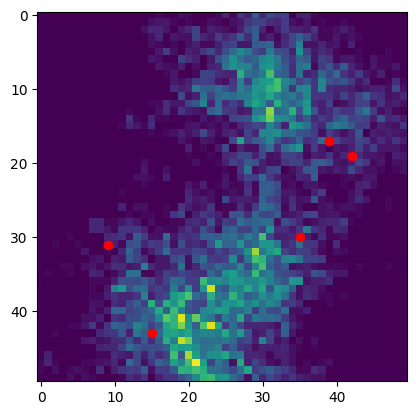

Nativos: 58388
Colonos: 10861
Batallas: 13542.0
Celdas ocupadas por colonos: 866
Step: 300


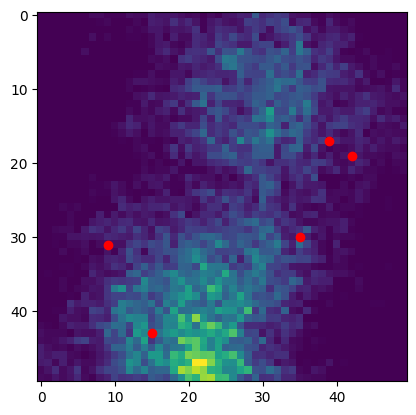

Nativos: 103472
Colonos: 20187
Batallas: 29242.0
Celdas ocupadas por colonos: 1030
Step: 400


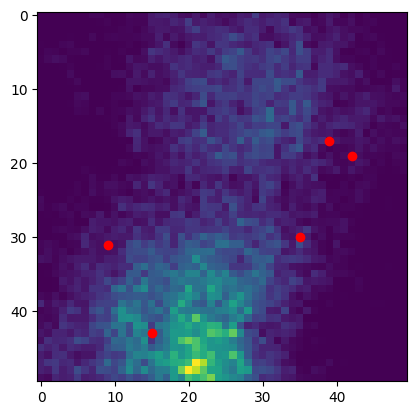

Nativos: 147226
Colonos: 31279
Batallas: 46168.0
Celdas ocupadas por colonos: 1206
Step: 500


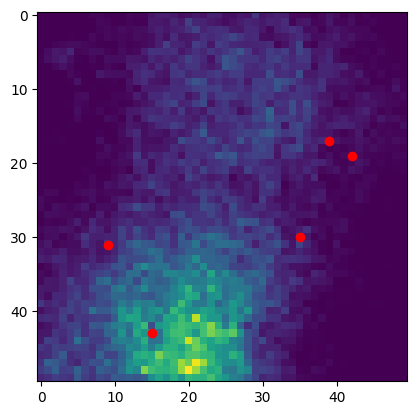

Nativos: 185534
Colonos: 45132
Batallas: 61815.0
Celdas ocupadas por colonos: 1377
Step: 600


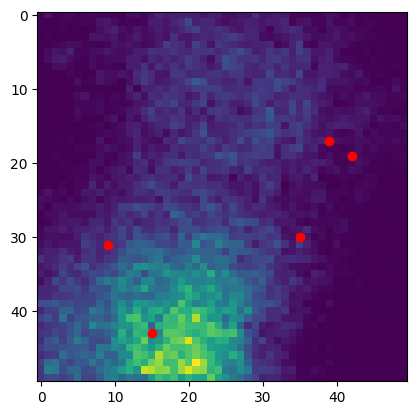

Nativos: 218256
Colonos: 61862
Batallas: 75763.0
Celdas ocupadas por colonos: 1625
Step: 700


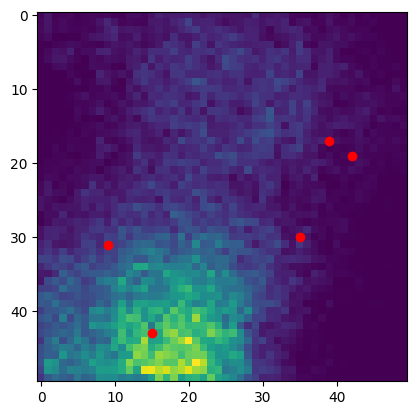

Nativos: 244396
Colonos: 80395
Batallas: 87263.0
Celdas ocupadas por colonos: 1808
Step: 800


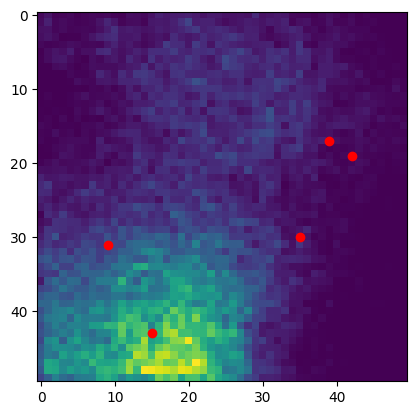

Nativos: 265709
Colonos: 102935
Batallas: 96745.0
Celdas ocupadas por colonos: 1953
Step: 900


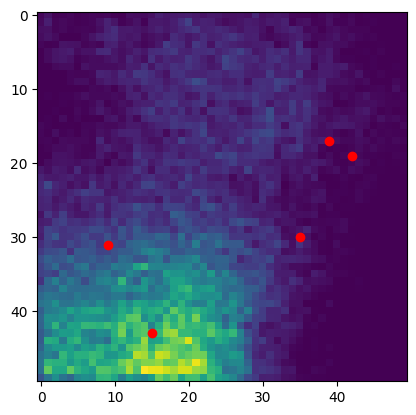

Nativos: 280812
Colonos: 126385
Batallas: 103438.0
Celdas ocupadas por colonos: 2187


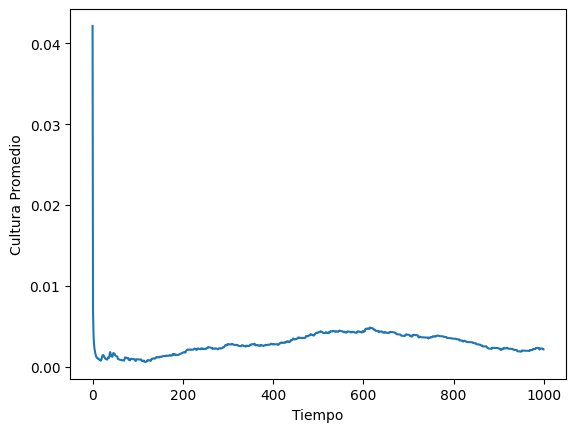

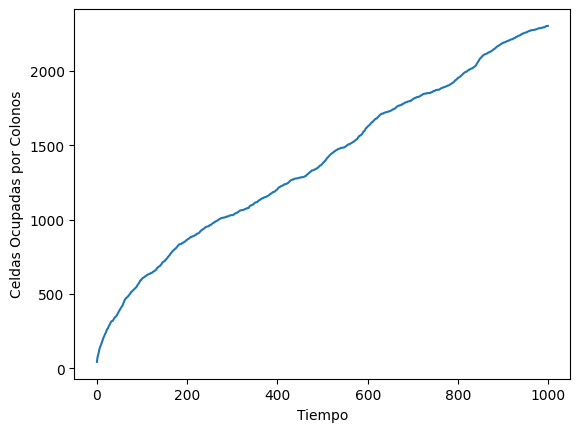

Sim 2
Step: 0


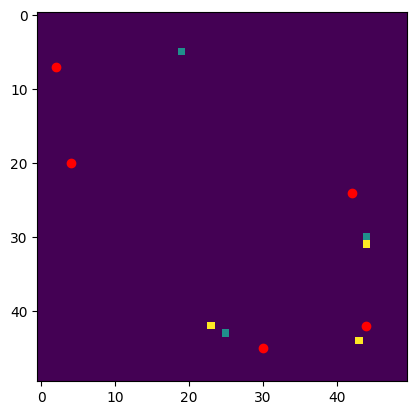

Nativos: 104
Colonos: 51
Batallas: 9.0
Celdas ocupadas por colonos: 38
Step: 100


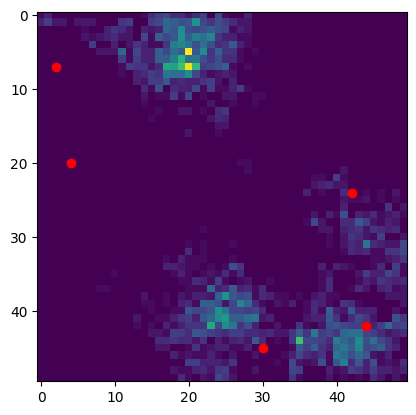

Nativos: 18490
Colonos: 5151
Batallas: 3293.0
Celdas ocupadas por colonos: 605
Step: 200


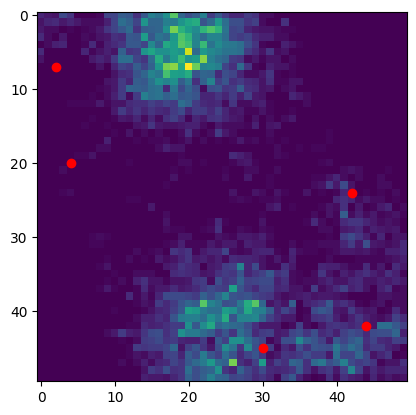

Nativos: 55153
Colonos: 11254
Batallas: 12137.0
Celdas ocupadas por colonos: 806
Step: 300


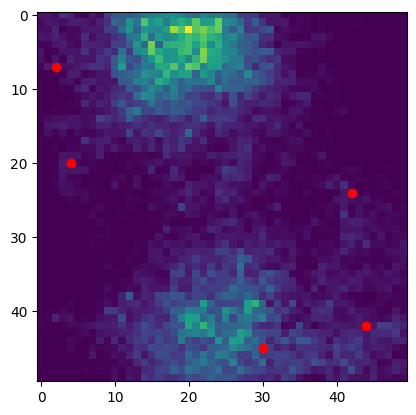

Nativos: 109883
Colonos: 20838
Batallas: 29341.0
Celdas ocupadas por colonos: 1043
Step: 400


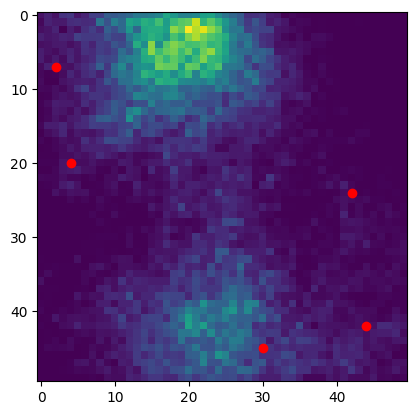

Nativos: 170566
Colonos: 31589
Batallas: 52459.0
Celdas ocupadas por colonos: 1175
Step: 500


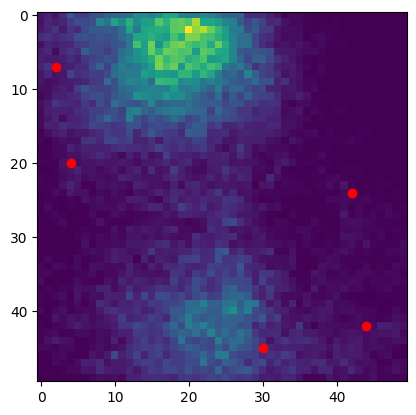

Nativos: 228384
Colonos: 44822
Batallas: 75740.0
Celdas ocupadas por colonos: 1339
Step: 600


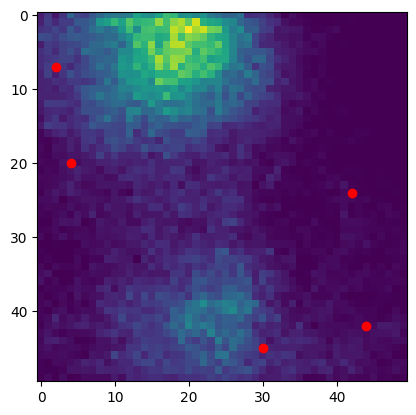

Nativos: 279001
Colonos: 60775
Batallas: 96790.0
Celdas ocupadas por colonos: 1475
Step: 700


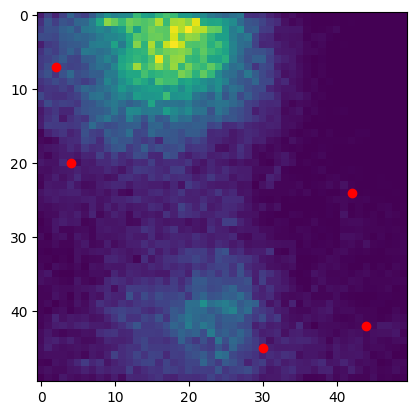

Nativos: 321475
Colonos: 78284
Batallas: 114848.0
Celdas ocupadas por colonos: 1613
Step: 800


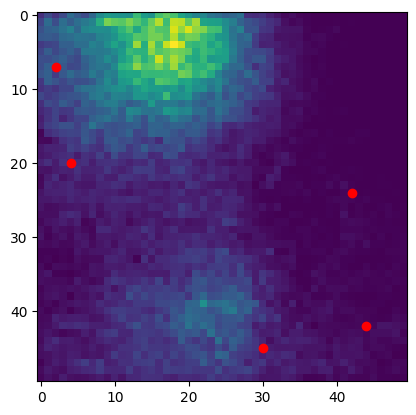

Nativos: 355944
Colonos: 99328
Batallas: 129798.0
Celdas ocupadas por colonos: 1744
Step: 900


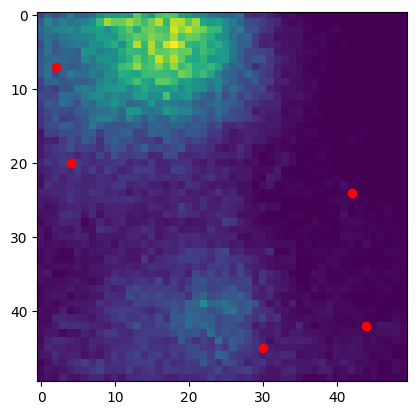

Nativos: 382425
Colonos: 121147
Batallas: 141295.0
Celdas ocupadas por colonos: 1890


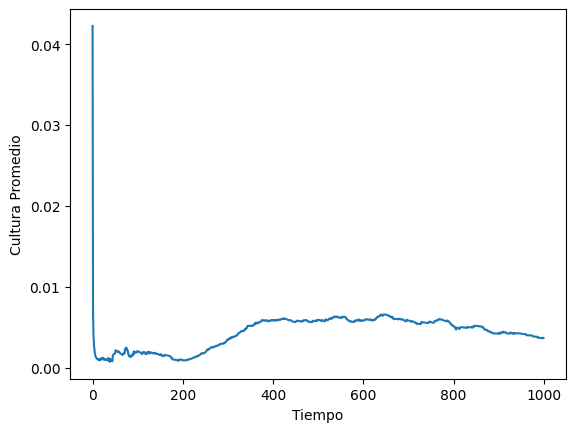

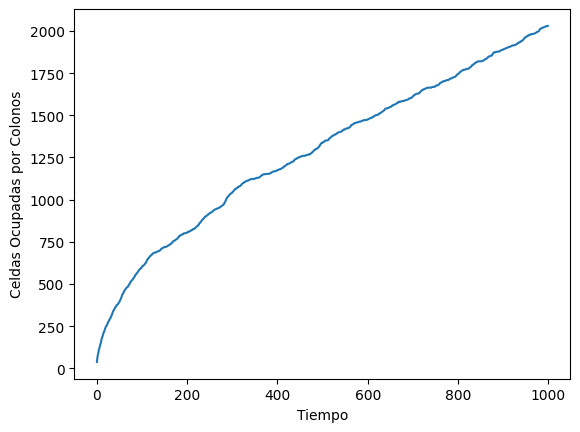

Sim 3
Step: 0


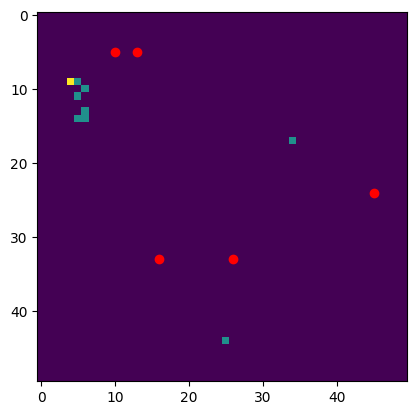

Nativos: 105
Colonos: 51
Batallas: 10.0
Celdas ocupadas por colonos: 37
Step: 100


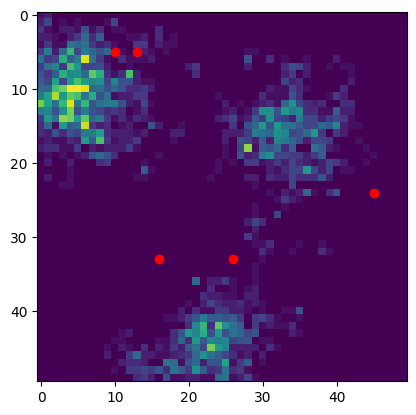

Nativos: 22190
Colonos: 5151
Batallas: 3451.0
Celdas ocupadas por colonos: 574
Step: 200


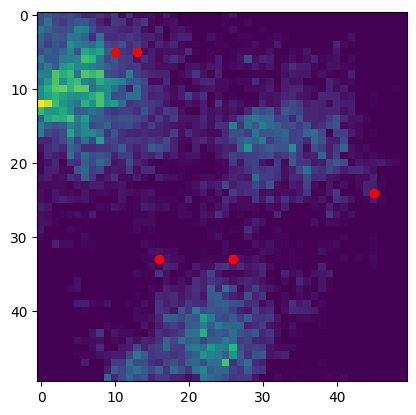

Nativos: 70264
Colonos: 11247
Batallas: 14769.0
Celdas ocupadas por colonos: 921
Step: 300


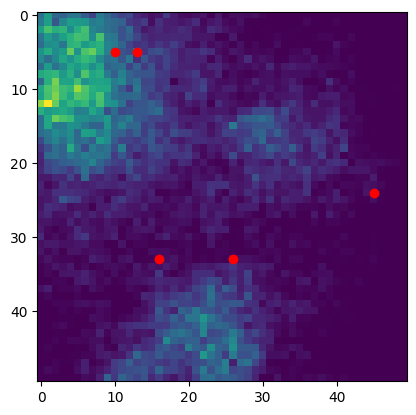

Nativos: 154186
Colonos: 21020
Batallas: 36921.0
Celdas ocupadas por colonos: 1186
Step: 400


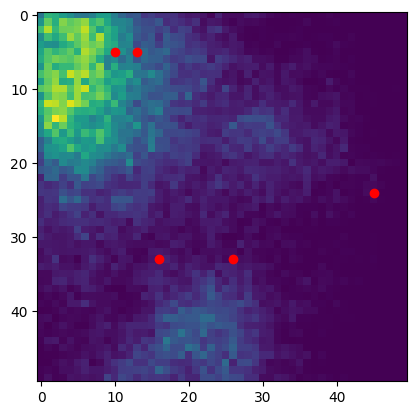

Nativos: 274037
Colonos: 32550
Batallas: 78089.0
Celdas ocupadas por colonos: 1388
Step: 500


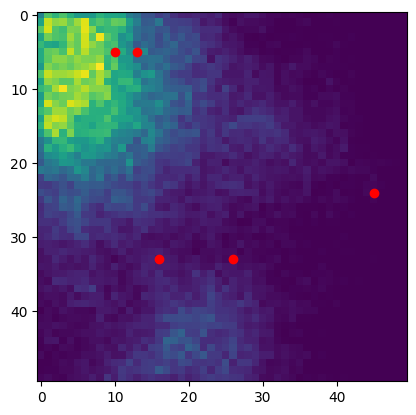

Nativos: 409965
Colonos: 46627
Batallas: 130692.0
Celdas ocupadas por colonos: 1489
Step: 600


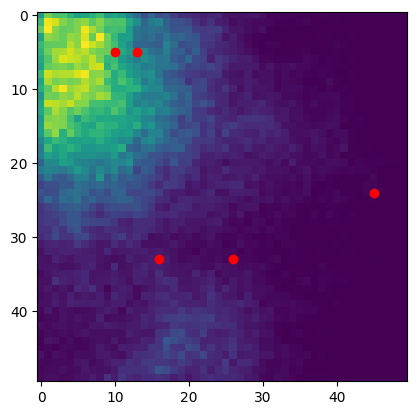

Nativos: 555493
Colonos: 63569
Batallas: 190823.0
Celdas ocupadas por colonos: 1579
Step: 700


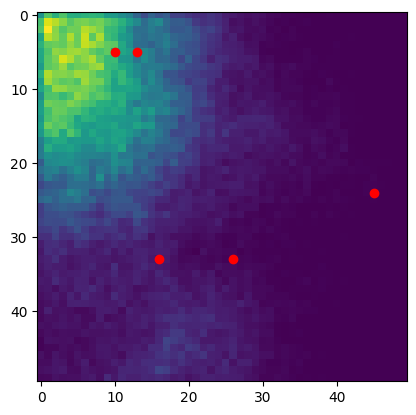

Nativos: 701557
Colonos: 81608
Batallas: 253295.0
Celdas ocupadas por colonos: 1677
Step: 800


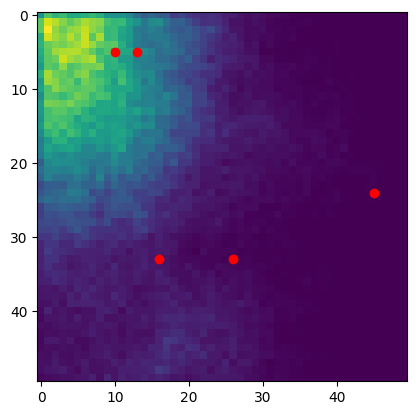

Nativos: 840713
Colonos: 102558
Batallas: 314209.0
Celdas ocupadas por colonos: 1788
Step: 900


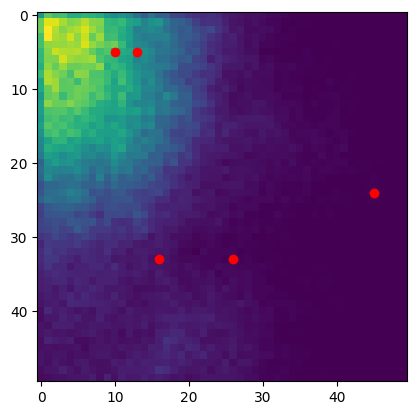

Nativos: 973068
Colonos: 123589
Batallas: 373188.0
Celdas ocupadas por colonos: 1828


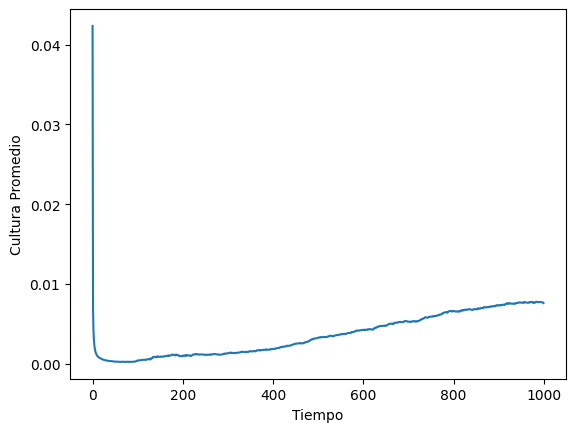

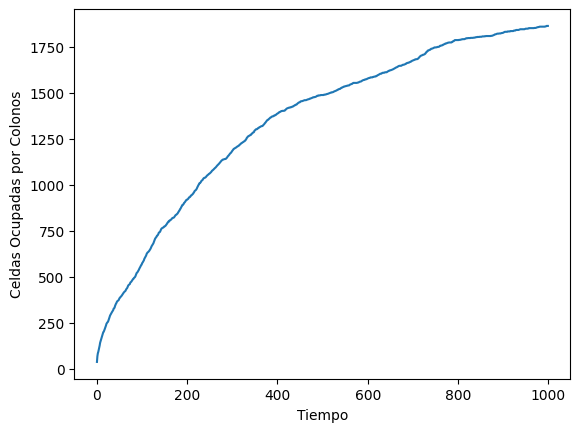

Sim 4
Step: 0


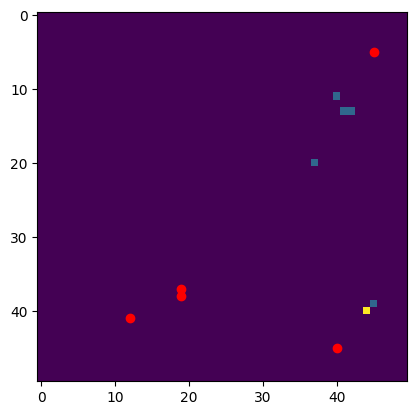

Nativos: 105
Colonos: 51
Batallas: 8.0
Celdas ocupadas por colonos: 39
Step: 100


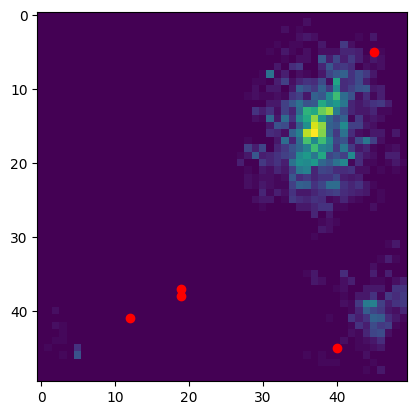

Nativos: 16072
Colonos: 5130
Batallas: 3562.0
Celdas ocupadas por colonos: 496
Step: 200


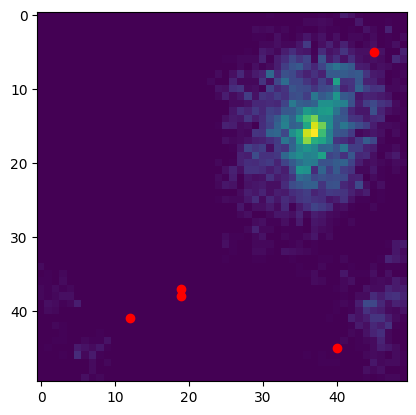

Nativos: 32820
Colonos: 11054
Batallas: 9219.0
Celdas ocupadas por colonos: 669
Step: 300


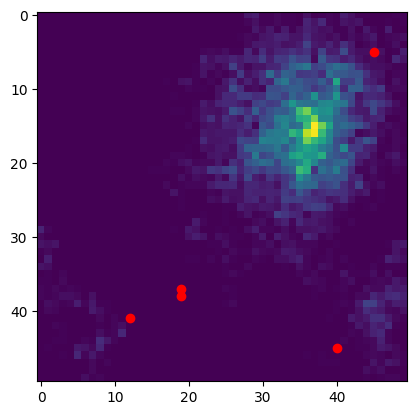

Nativos: 44322
Colonos: 20703
Batallas: 13566.0
Celdas ocupadas por colonos: 917
Step: 400


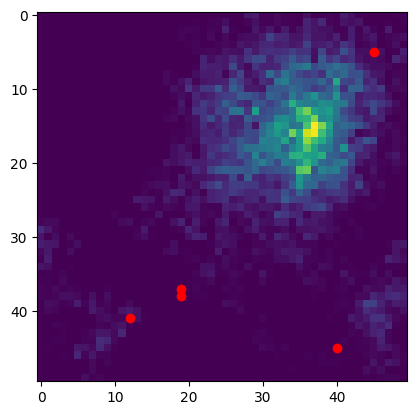

Nativos: 51822
Colonos: 32353
Batallas: 16631.0
Celdas ocupadas por colonos: 1127
Step: 500


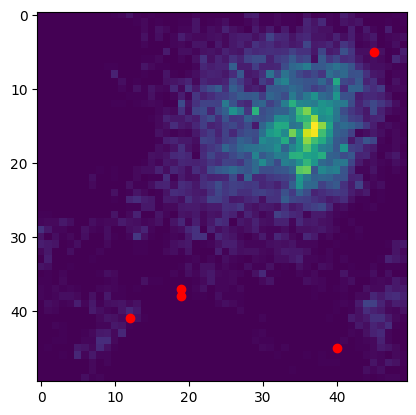

Nativos: 56606
Colonos: 46953
Batallas: 18531.0
Celdas ocupadas por colonos: 1296
Step: 600


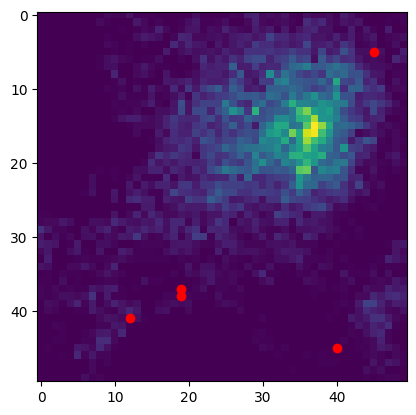

Nativos: 59774
Colonos: 64603
Batallas: 19830.0
Celdas ocupadas por colonos: 1531
Step: 700


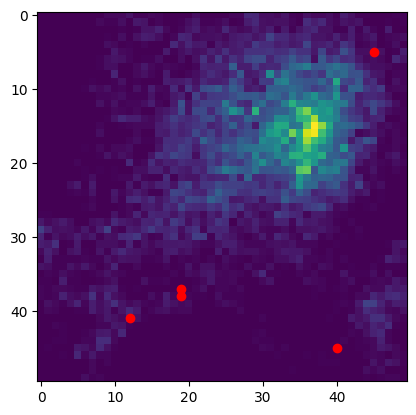

Nativos: 61958
Colonos: 84203
Batallas: 20756.0
Celdas ocupadas por colonos: 1679
Step: 800


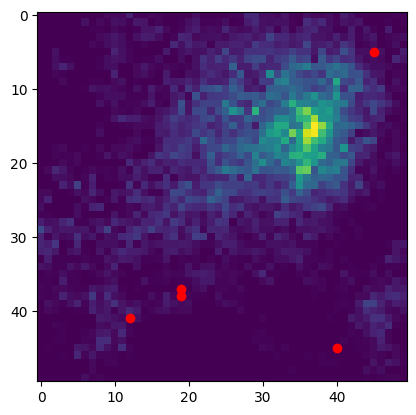

Nativos: 63437
Colonos: 107853
Batallas: 21368.0
Celdas ocupadas por colonos: 1802
Step: 900


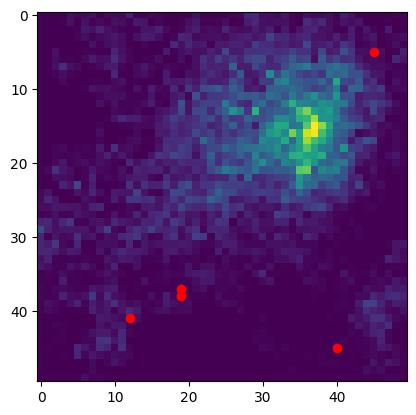

Nativos: 64370
Colonos: 132503
Batallas: 21782.0
Celdas ocupadas por colonos: 1970


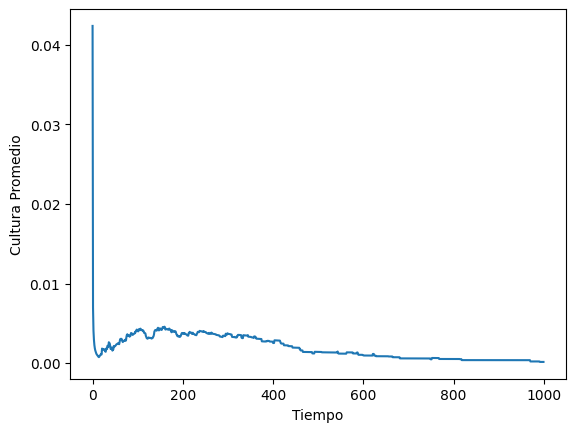

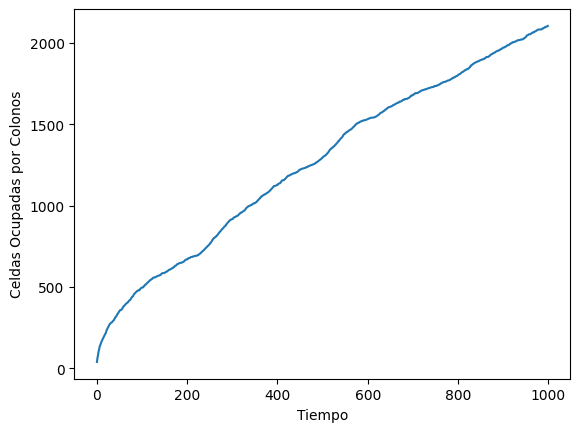

Sim 5
Step: 0


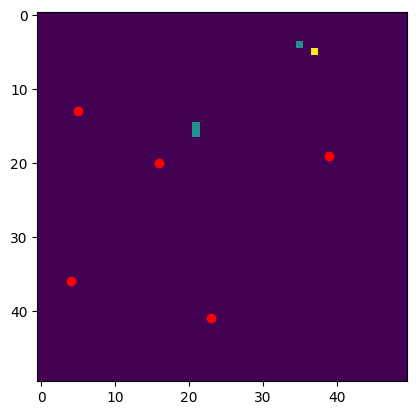

Nativos: 106
Colonos: 51
Batallas: 5.0
Celdas ocupadas por colonos: 41
Step: 100


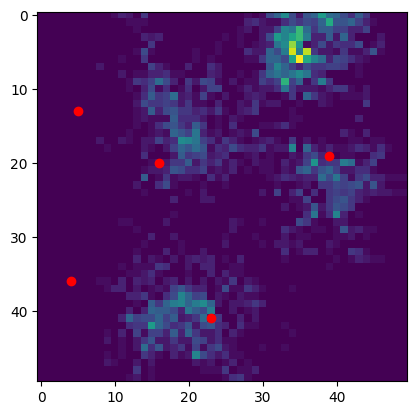

Nativos: 20490
Colonos: 5046
Batallas: 3651.0
Celdas ocupadas por colonos: 540
Step: 200


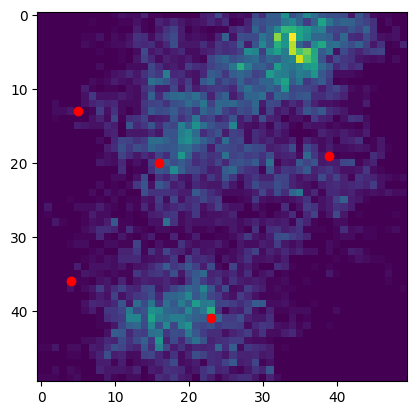

Nativos: 61137
Colonos: 10726
Batallas: 14882.0
Celdas ocupadas por colonos: 759
Step: 300


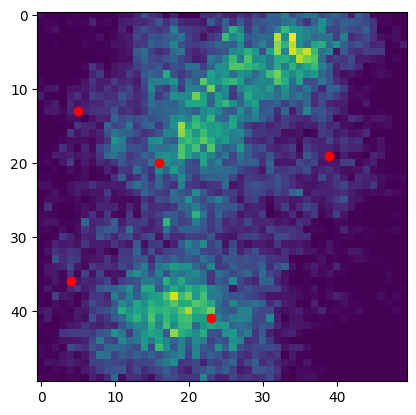

Nativos: 113017
Colonos: 20137
Batallas: 33402.0
Celdas ocupadas por colonos: 998
Step: 400


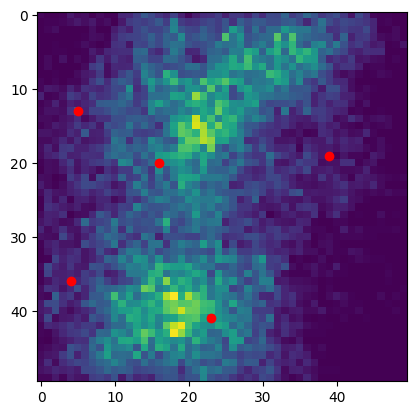

Nativos: 165136
Colonos: 31486
Batallas: 54257.0
Celdas ocupadas por colonos: 1197
Step: 500


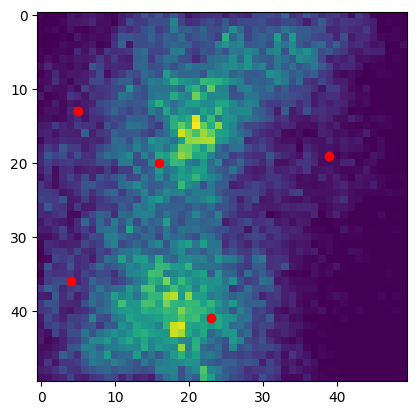

Nativos: 212461
Colonos: 45686
Batallas: 74200.0
Celdas ocupadas por colonos: 1357
Step: 600


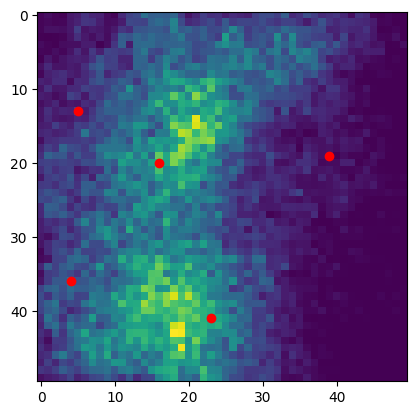

Nativos: 253740
Colonos: 62834
Batallas: 92073.0
Celdas ocupadas por colonos: 1434
Step: 700


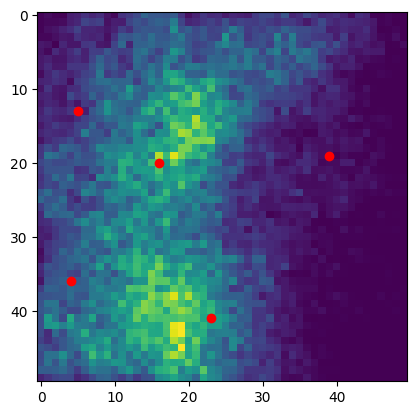

Nativos: 290831
Colonos: 81785
Batallas: 108620.0
Celdas ocupadas por colonos: 1561
Step: 800


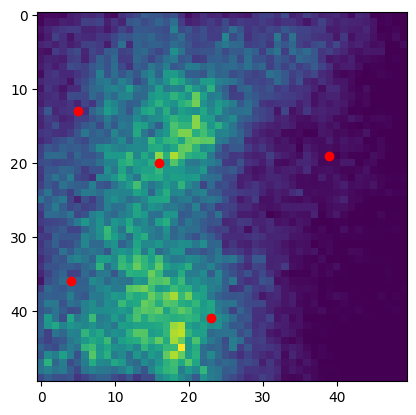

Nativos: 321632
Colonos: 104608
Batallas: 122487.0
Celdas ocupadas por colonos: 1674
Step: 900


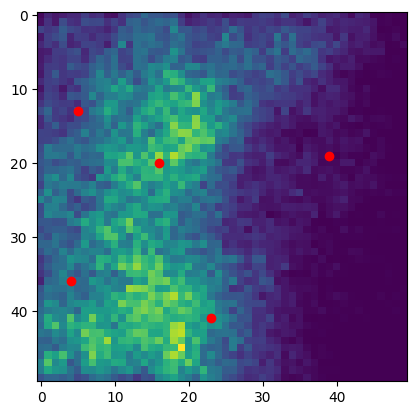

Nativos: 346207
Colonos: 128346
Batallas: 133681.0
Celdas ocupadas por colonos: 1869


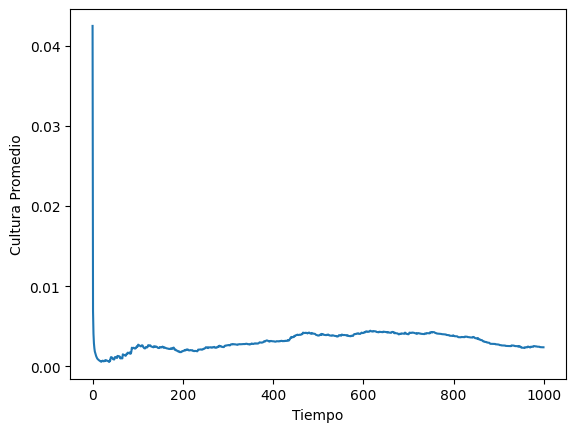

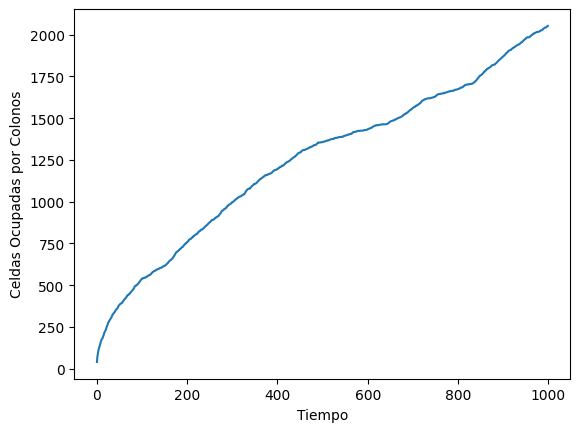

In [35]:
simular(5, 1000)